# Lecture #4: Implementing Tools from Paper \#1
## The first step: Exploratory Data Analysis

We will begin by unpickling the dataset we had played around with in the Data Cleaning notebook for this lecture. But first, as always, we will load most modules we will be using:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt
import itertools
import pickle

%matplotlib inline

To unpickle just do this:

In [4]:
pickle_file = open('data/campusDemand.pkl','rb')
pickled_data = pickle.load(pickle_file)
pickle_file.close()

# Since we pickled them all together as a list, I'm going to assign each element of the list to the same variable
# we had been using before:
data = pickled_data[0]
pointNames = pickled_data[1]
data_by_day = pickled_data[2]
idx = pickled_data[3]

This notebook is largely the content of Assignment #2 for the 2016 version of this course.

## -=-=-= Exploring hourly and weekly consumption patterns (no seasonality) =-=-=-

# Task \#1

Create a new Pandas Data Frame that contains only two columns (Time and Value) and only the rows that belong to the University-wide meter (Electric kW Calculations Main Campus). In other words, get rid of the Point Name column and select only the rows for the campus meter.

In [5]:
# Your code goes here

data = data[data['Point name'] == pointNames[5]]
data = data.drop(data.columns[0],axis=1)

# Task \#2

In one figure, plot one histogram showing the average hourly consumption on the entire dataset.
In a separate figure, plot 7 subplots with similar histograms but now showing the average hourly consumption for each day of the weeek (hence the 7 supplots).

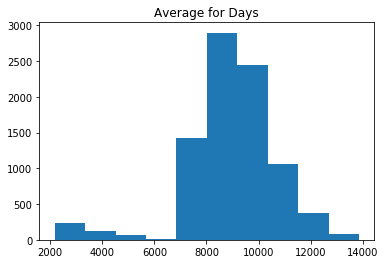

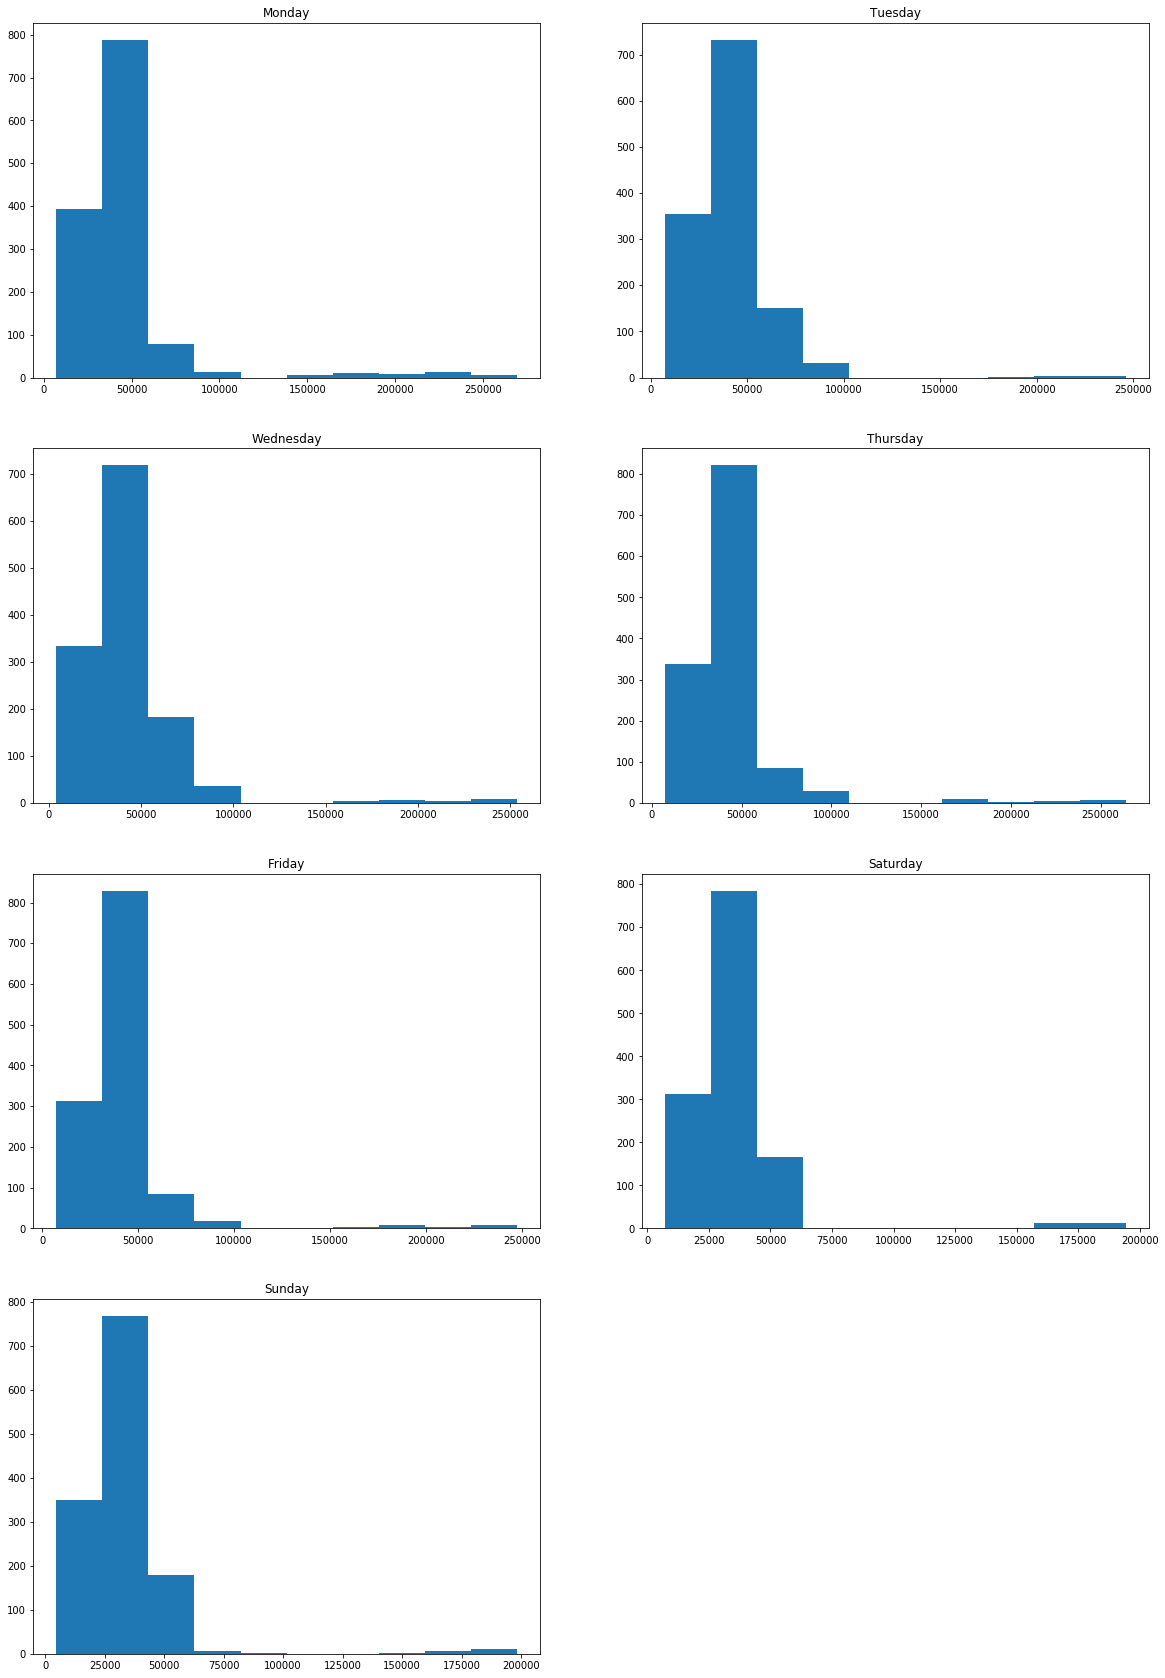

In [7]:
# Your code goes here

hourlyDemand = data.groupby(round(data['Time'].astype('int64')/(10**9*60*60)))
                    
# Plot #1

fig1 = plt.figure()
plt.hist(hourlyDemand['Value'].mean())
plt.title('Average for Days')

# Plot #2
daysOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
fig2 = plt.figure(figsize=(20,30))
for i,day in enumerate(data_by_day):
    plt.subplot(4,2,i+1) # 4 rows and 2 columns of subplots
    plt.hist(day.groupby(round(day['Time'].astype('int64')/(10**9*60*60)))['Value'].mean())
    plt.title(daysOfWeek[i])
    
    


# Task \#3

In one figure, create a box plot of the average hourly electricity consumption for each hour of the day (i.e., your plot will show 24 *boxes*, one for each hour of the day, and each *box* will represent the distribution of the average hourly consumption in the dataset for that hour).

In another figure, create 7 subplots showing the same box plots as above, but now for each of the seven days of the week.

/Users/mberges/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


0         AxesSubplot(0.1,0.736957;0.363636x0.163043)
1    AxesSubplot(0.536364,0.736957;0.363636x0.163043)
2         AxesSubplot(0.1,0.541304;0.363636x0.163043)
3    AxesSubplot(0.536364,0.541304;0.363636x0.163043)
4         AxesSubplot(0.1,0.345652;0.363636x0.163043)
5    AxesSubplot(0.536364,0.345652;0.363636x0.163043)
6             AxesSubplot(0.1,0.15;0.363636x0.163043)
dtype: object

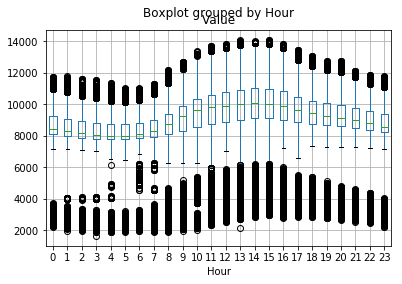

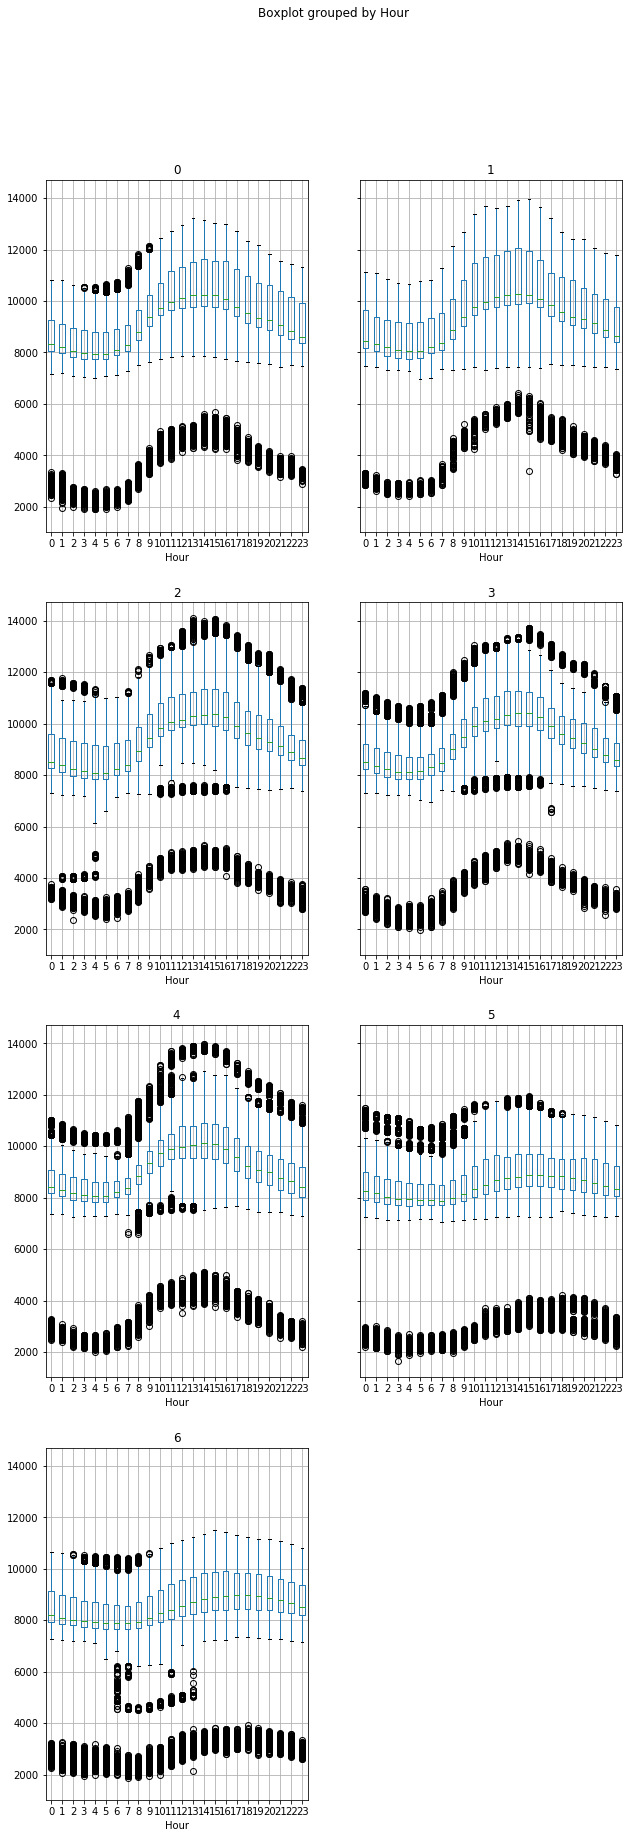

In [13]:
# Your code goes here

data['Hour'] = data['Time'].dt.hour
data['Weekday'] = data['Time'].dt.dayofweek
data.boxplot(by="Hour",column=['Value'])

data.groupby('Weekday').boxplot(by="Hour",column=['Value'],figsize=(10,30),layout=(4,2))

## -=-=-= Exploring seasonal effects =-=-=-

# Task \#4

Create a **stem plot** of the average daily electricity consumption for the whole dataset (i.e., the plot should have ~365 stems):

<Container object of 3 artists>

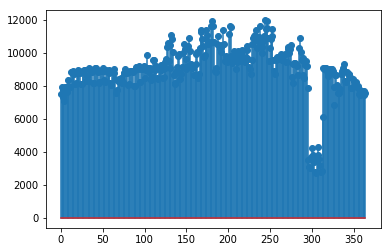

In [15]:
# Your code goes here
plt.stem(data.groupby(data['Time'].dt.dayofyear)['Value'].mean())


# Task \#6

Create a new DataFrame called ```loadCurves```, which contains 24 columns (one for each hour of the day) and each of those columns has a Series with as many rows as there are days in our dataset. Each column wil be composed of the average power consumed during that particular hour for each day of the year.

Note: You may benefit from knowing about the ```groupby``` and ```unstack``` methods for DataFrames.

In [16]:
# Your code goes here...

data['DayOfYear'] = data['Time'].dt.dayofyear
loadCurves = data.groupby(['DayOfYear', 'Hour'])['Value'].mean().unstack()

f = open('data/loadCurves.pkl','wb')
pickle.dump([data,loadCurves],f)
f.close()

# Task \#7
Create a heatmap of the daily load curves for campus, similar to those shown in Paper \#1. In particular, this heatmap will be a 2D map with the horizontal axis showing the hours of the day (24 in total), and the vertical axis showing the day of the year (~365 total). Then each cell will be color-coded with the value corresponding to the average power consumed during this hour. 

Try different colormaps to see which one works best for you.

Note: you may need to normalize the data to see differences. 

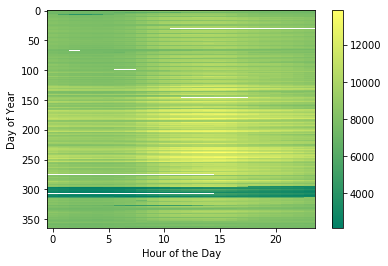

In [17]:
# Your code goes here...
import matplotlib.colors as clrs

#plt.pcolor(loadCurves,cmap='summer',norm=clrs.Normalize(),vmin=loadCurves.min().min(), vmax=loadCurves.max().max())
plt.imshow(loadCurves, aspect='auto',cmap='summer')
plt.ylabel('Day of Year')
plt.xlabel('Hour of the Day')
plt.colorbar()

# Task \#8

Let's see if we can find some patterns in these load curves. Using your favorite implementation and flavor of the k-means algorithm, play around with clustering the daily loadCurves to see if we can find 2 or 3 clusters that would best differentiate between weekdays and weekends. In other words, perform k-means (or k-medioids, or whatever) on the dataset with $k \in \{2, 3\}$ and the dataset being 365 samples of 24-dimensional vectors.

Note: you will only check the weekend vs. weekday labels **after** clustering (i.e., do not use this attribute for clustering, but rather only the 24 average hourly consumption values).

(348, 24)


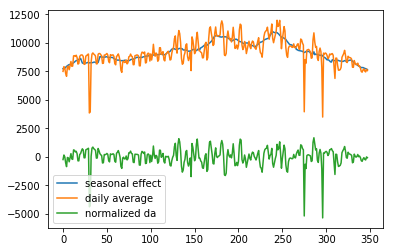

In [18]:
# Your code goes here...

from sklearn.cluster import KMeans

# Clean it up
loadCurves = loadCurves.replace(np.inf,np.nan).fillna(0)


# Make it compatible with sklearn:
X = loadCurves.as_matrix().astype(np.float32)
## remove days with weird consumption pattern, as shown in stem plot above
X = np.concatenate([X[:297,:],X[314:,:]])
print(X.shape)

#since we are interested in weekdays/weekends, lets subtract the seasonal effects
#here I compute a naive low-pass over 10 days
lp = 10
seasonal = []
for i in range(int(len(X))):
    seasonal.append(np.mean(X[np.max([i-lp,0]):i+lp,:]))
    

plt.plot(seasonal, label='seasonal effect')
plt.plot(np.mean(X,axis=1), label='daily average')

X = (X.T - seasonal).T
plt.plot(np.mean(X,axis=1), label='normalized da')
plt.legend()

# Find the clusters
clusters = KMeans(n_clusters=3).fit(X)

# Task \#9 (10%)

In separate plots (one for each cluster), plot the cluster centroids (in a dark, thick line) and the load curves that belong to the cluster (using thin grayish lines), just like the paper did. 

What did you learn from the experiment above?

137
208
3


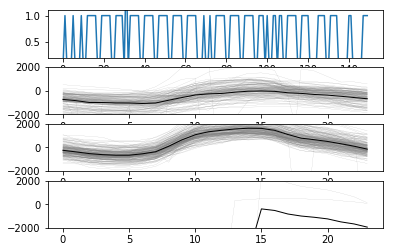

In [19]:
num_clust = 3

cluster_assignments = clusters.predict(X)
plt.subplot(num_clust+1,1,1)
plt.plot(cluster_assignments[:150])
plt.ylim([0.2,1.1])

for cluster_id in range(len(clusters.cluster_centers_)):
    plt.subplot(num_clust+1,1,cluster_id+2)
    cluster_members = X[cluster_assignments==cluster_id,:]
    print(len(cluster_members))
    for i in range(len(cluster_members)):
        plt.plot(cluster_members[i,:], color='grey', lw='0.1')
    plt.plot(clusters.cluster_centers_[cluster_id,:], color='k', lw='1')
    plt.ylim([-2000,2000])